In [1]:
# Create contact sheet with avg maps and real cell instances. First part of this
# notebook computes std of representations that were not computed by default using
# cvapipe_analysis

In [2]:
!date

Mon Jun 27 19:14:05 PDT 2022


In [3]:
import os
import sys
import json
import pickle
import importlib
import concurrent
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
from skimage import io as skio
import matplotlib.pyplot as plt
from aicscytoparam import cytoparam
from aicsshparam import shtools, shparam
from aicsimageio import AICSImage
from aicsimageio.writers import OmeTiffWriter
from cvapipe_analysis.tools import io, viz, general, controller, shapespace, plotting

sys.path.insert(1, '../tools')
import common

In [4]:
# Controller form cvapipe_analysis
path_config = Path("/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/")
control = controller.Controller(general.load_config_file(path_config))
print(control.get_staging())

/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_variance


In [5]:
device = io.LocalStagingIO(control)
df = device.load_step_manifest("preprocessing")
space = shapespace.ShapeSpace(control)
space.execute(df)

In [6]:
df_sphere, df_dist = space.get_cells_inside_ndsphere_of_radius(return_dist=True)
df_sphere = df_sphere.set_index("structure", verify_integrity=True)
df_sphere.head()

,shape_mode,mpId,aggtype,alias,CellIds
structure,,,,,
AAVS1,NdSphere,5,avg,STR,"[466246, 466260, 466261, 466262, 466264, 46626..."
ACTB,NdSphere,5,avg,STR,"[230792, 230794, 230817, 230844, 230850, 23086..."
ACTN1,NdSphere,5,avg,STR,"[524579, 524603, 524679, 524688, 524692, 52469..."
ATP2A2,NdSphere,5,avg,STR,"[734388, 734509, 734720, 734722, 734729, 73485..."
CETN2,NdSphere,5,avg,STR,"[230809, 230831, 230833, 230843, 230980, 23098..."


### Aggregate representations inside 8D sphere and calculate structure-localized coefficient of variation

In [7]:
%%time
def get_rep(CellId):
    rep = device.read_parameterized_intensity(CellId)
    return rep

if not os.path.exists("./data.pkl"):
    print("Running aggregation...")
    data = {}
    for gene, row in df_sphere.iterrows():
        CellIds = row.CellIds
        with concurrent.futures.ProcessPoolExecutor(control.get_ncores()) as executor:
            reps = list(tqdm(executor.map(get_rep, CellIds), total=len(CellIds), leave=False, desc=gene))
        reps = np.array(reps)
        data[gene] = {"mean": reps.mean(axis=0), "std": reps.std(axis=0)}
        
    with open("data.pkl", "wb") as fp:
        pickle.dump(data, fp)
else:
    print("Loading pre-computed aggregation...")
    with open("data.pkl", "rb") as fp:
        data = pickle.load(fp)

Loading pre-computed aggregation...
CPU times: user 26.2 ms, sys: 54.3 ms, total: 80.5 ms
Wall time: 1.12 s


In [8]:
data_backup = data.copy()

In [9]:
for gene, agg in tqdm(data.items(), total=len(data)):
    slcv = agg["std"].copy()
    valids = np.where(agg["mean"]>0)
    slcv[valids] /= agg["mean"][valids]
    threshold = np.median(agg["mean"][valids])
    slcv[agg["mean"]<threshold] = 0
    data[gene].update({"slcv": slcv})

  0%|          | 0/25 [00:00<?, ?it/s]

### Create the domain to morph aggregations into

In [10]:
space = shapespace.ShapeSpaceBasic(control)
variables = control.get_variables_values_for_aggregation()
df = space.get_aggregated_df(variables).drop(columns=["structure"]).drop_duplicates().reset_index(drop=True)
df = df.loc[df.mpId==control.get_center_map_point_index()].head(1)
df

,shape_mode,mpId,aggtype,alias
4,NUC_MEM_PC1,5,avg,STR


In [11]:
row = df.loc[df.index[0]]
device = io.LocalStagingIO(control)
device.row = row

In [12]:
nisos = control.get_number_of_interpolating_points()
inner_alias = control.get_inner_most_alias_to_parameterize()
inner_mesh = device.read_map_point_mesh(inner_alias)
outer_alias = control.get_outer_most_alias_to_parameterize()
outer_mesh = device.read_map_point_mesh(outer_alias)
domain, origin = cytoparam.voxelize_meshes([outer_mesh, inner_mesh])
coords_param, coeffs_centroid = cytoparam.parameterize_image_coordinates(
    seg_mem=(domain>0).astype(np.uint8),
    seg_nuc=(domain>1).astype(np.uint8),
    lmax=control.get_lmax(), nisos=[nisos, nisos]
)
coeffs_mem, centroid_mem, coeffs_nuc, centroid_nuc = coeffs_centroid
coords_param += np.array(centroid_nuc).reshape(3, 1, 1)-np.array(centroid_mem).reshape(3, 1, 1)

In [13]:
domain_nuc = (255*(domain>1)).astype(np.uint8)
domain_mem = (255*(domain>0)).astype(np.uint8)

### Morph aggregations into domain

In [14]:
importlib.reload(common)

<module 'common' from '/allen/aics/assay-dev/MicroscopyOtherData/Viana/projects/cvapipe_analysis/local_staging_notebooks/FigureMorphingOverflow/../tools/common.py'>

In [15]:
with open("../MovieALPBaseline/contrast_V3_90OnValids.json", "r") as fj:
    contrast = json.load(fj)["contrast"]

In [16]:
genes = control.get_gene_names()

In [17]:
pct_agg = {"std": 99, "slcv": 99}

  0%|          | 0/25 [00:00<?, ?it/s]

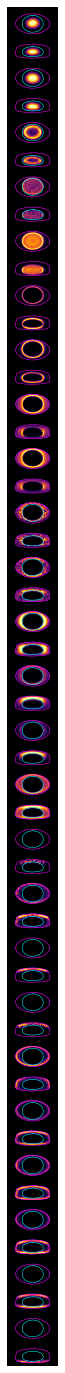

  0%|          | 0/25 [00:00<?, ?it/s]

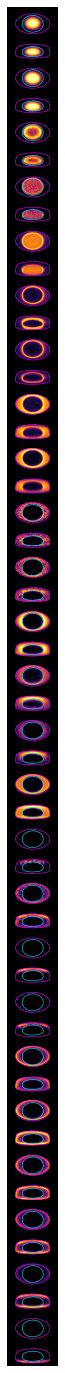

  0%|          | 0/25 [00:00<?, ?it/s]

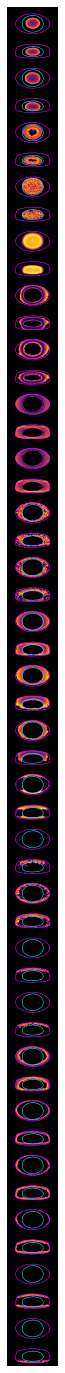

In [19]:
bbox = 300

for agg in ["mean", "std", "slcv"]:

    morphs = {}
    for gene in tqdm(genes):
        morphed = cytoparam.morph_representation_on_shape(
            img=domain,
            param_img_coords=coords_param,
            representation=data[gene][agg]
        )
        morphed = np.stack([domain_nuc, domain_mem, morphed], axis=0)
        morphs[gene] = morphed

    contrast_to_use = contrast
        
    if agg != "mean":        
        contrast_specific = {}
        for gene in genes:
            mode = {"nuc":"center_nuc","mem":"center_nuc","gfp":"center_nuc"}
            contrast_specific[gene] = common.Projector.get_shared_morphed_max_based_on_pct_for_zy_views(
                instances = [morphs[gene]],
                pct = pct_agg[agg],
                mode = mode,
                func = np.max
            )
            contrast_to_use = contrast_specific
        
    instances = dict([(gene, [{"CellId": "mean","img": morphs[gene]}]) for gene in genes])

    common.make_contact_sheet_avgseg_channel(
        data = instances,
        bbox = bbox,
        contrast = contrast_to_use,
        file_prefix = f"FigureMorphingOverflow1_{agg}",
        ylow = 90,
        zlow = 50,
        nucleus_contour_off = ["LMNB1", "NUP153", "SEC61B", "ATP2A2", "HIST1H2BJ"]
    )

### Real instances

In [ ]:
# ncells = 3
# df_sphere = df_sphere.reset_index()

In [ ]:
# df = device.load_step_manifest("preprocessing")

In [ ]:
# not_ideal_ids = [456052, 897693, 976302, 1001597, 994640, 630239, 250641, 468572]

In [ ]:
# data = {}
# for gene in tqdm(genes):
    
#     CellIds = df_sphere.loc[df_sphere.structure==gene, "CellIds"].values[0]
#     # Sort CellIds by distance from origin
#     CellIds = df_dist.loc[CellIds].sort_values("Distance").index.values
#     CellIds = [c for c in CellIds if c not in not_ideal_ids][:ncells]
#     print(gene, CellIds)
    
#     producers = []
#     for CellId in tqdm(CellIds, leave=False, desc=gene):
#         row = df.loc[CellId]
#         row = common.redirect(row)
#         producer = io.DataProducer(control)
#         producer.set_row(row)
#         producer.load_single_cell_data()
#         producer.align_data()
#         producers.append(producer)
#     data[gene] = [p.data_aligned[[3, 5, 7]] for p in producers]

In [ ]:
# # cell and nuc masks
# mode = {
#     "nuc":"max",
#     "mem":"max",
#     "gfp":"mean"
# }
# args = {"gridspec_kw": {"hspace": 0, "wspace": 0}, "sharex": True, "sharey": True}
# for alias in ["nuc", "mem"]:
#     fig, axes = plt.subplots(len(genes), ncells, figsize=(1*ncells,len(genes)*yx), **args)
#     for gid, (gene, axs) in enumerate(zip(genes, axes)):
#         for instance, ax in zip(data[gene], axs):
#             ax.axis("off")
#             proj = common.Projector(instance)
#             proj.set_projection_mode(ax="z", mode=mode)
#             proj.compute()
#             pz = proj.projs[alias].copy()
#             proj.set_projection_mode(ax="y", mode=mode)
#             proj.compute()
#             py = proj.projs[alias].copy()
#             im = np.concatenate([py[yyi:yyf, :], pz[yzi:yzf, :]], axis=0)
#             ax.imshow(im, cmap="gray", origin="lower")
#     plt.savefig(f"FigureMorphingOverflow1_inst_{alias}", dpi=150)
#     plt.show()

In [ ]:
# for alias in ["gfp"]:
#     fig, axes = plt.subplots(len(genes), ncells, figsize=(1*ncells,len(genes)*yx), **args)
#     for gid, (gene, axs) in enumerate(zip(genes, axes)):
#         for instance, ax in zip(data[gene], axs):
#             ax.axis("off")
#             proj = common.Projector(instance)
#             proj.set_projection_mode(ax="z", mode=mode)
#             proj.set_gfp_percentiles((20, 95), local=True)
#             proj.compute()
#             pz = proj.projs[alias].copy()
#             proj.set_projection_mode(ax="y", mode=mode)
#             proj.compute()
#             py = proj.projs[alias].copy()
#             im = np.concatenate([py[yyi:yyf, :], pz[yzi:yzf, :]], axis=0)
#             ax.imshow(im, cmap="binary", origin="lower", vmin=proj.gfp_vmin, vmax=proj.gfp_vmax)
#     plt.savefig(f"FigureMorphingOverflow1_inst_{alias}", dpi=150)
#     plt.show()